Configure notebook...

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Imports

In [18]:
from pathlib import Path
import pandas as pd
from IPython.display import IFrame, HTML, Markdown, Image, display

Define benchmark

In [19]:
OUT_DIR_BASE = "out"
BENCH = "tarfind"
DATE = "latest"

Lookup directories

In [20]:
BENCH_DIR = Path(OUT_DIR_BASE) / BENCH
assert BENCH_DIR.is_dir()
if DATE == "latest":
    dates = [f for f in BENCH_DIR.iterdir() if f.is_dir()]
    assert len(dates) > 0
    if len(dates) == 1:
        DATE = dates[0].name
    else:
        raise NotImplementedError("date lookup")
DATE_DIR = BENCH_DIR / DATE
assert DATE_DIR.is_dir()

print(f"Picked date: {DATE}")
print(f"Directory: {DATE_DIR}")

RUN = DATE_DIR / "run"
SESS = DATE_DIR / "sess"
WORK = DATE_DIR / "work"

PLOTS_DIR = SESS / "plots"

Picked date: 20241111T020624
Directory: out/tarfind/20241111T020624


Check baseline benchmark (ISS)

In [21]:
REPORT = RUN / "report.csv"

COLS = ["Model", "Run Instructions", "Total ROM", "Total RAM"]
pd.read_csv(REPORT)[COLS]

,Model,Run Instructions,Total ROM,Total RAM
0,tarfind,1212314,44264,11684


## Trace Analysis

### Identification of Bottlenecks

Per basic-block

In [22]:
IFrame(PLOTS_DIR / "runtime_per_llvm_bb.jpg", 700, 350)

Per function

In [23]:
IFrame(PLOTS_DIR / "runtime_per_func.jpg", 700, 350)

Per library

In [24]:
IFrame(PLOTS_DIR / "runtime_per_library.jpg", 700, 350)

Per object

In [25]:
IFrame(PLOTS_DIR / "runtime_per_object.jpg", 700, 350)

### Analyze instruction types

Per major opcode

In [26]:
IFrame(PLOTS_DIR / "runtime_per_opcode.jpg", 700, 350)

Per instruction name

In [27]:
IFrame(PLOTS_DIR / "runtime_per_instr.jpg", 700, 350)

### Choose BBs for ISE identification

In [28]:
CHOICES = SESS / "table" / "choices.pkl"

choices_df = pd.read_pickle(CHOICES)
choices_df

,func_name,bb_name,rel_weight,num_instrs,freq
0,rand_beebs,%bb.0,0.382539,13.0,36190.0
1,benchmark_body,%bb.5,0.323687,11.0,36190.0


## Identification of ISE candidates

### Per Func+BB

Filtered candidates

,Label,Count
0,Iso,127
1,Filtered (I/O),32
2,Filtered (Mem),8
3,Filtered (Operands),8
4,Selected,4


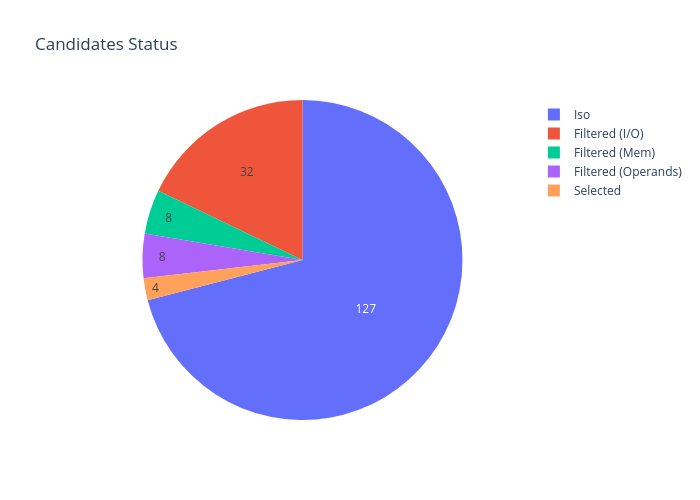

,Label,Count
0,Iso,226
1,Filtered (I/O),51
2,Filtered (Operands),17
3,Selected,8
4,Filtered (Mem),2


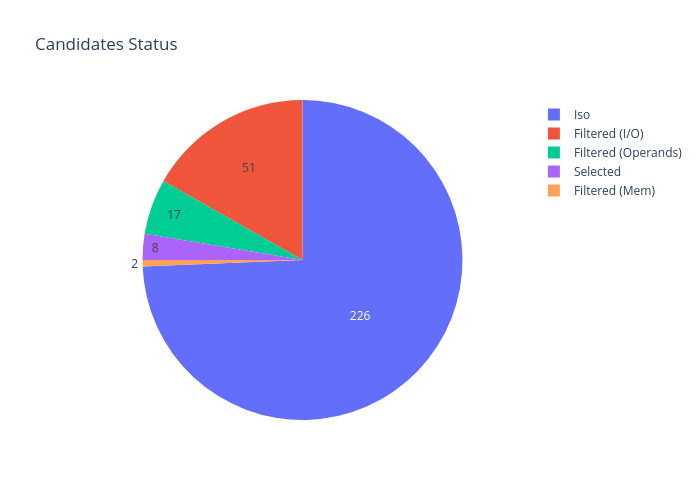

In [29]:
for _, row_data in choices_df.iterrows():
    func_name = row_data["func_name"]
    bb_name = row_data["bb_name"]
    func_bb_dir = WORK / f"{func_name}_{bb_name}_0"  # TODO: chekc suffix?
    pie_csv = func_bb_dir / "pie.csv"
    pie_img = func_bb_dir / "pie.png"
    display(HTML(f"<h2>Func: {func_name}, BB: {bb_name}</h2>"))
    display(pd.read_csv(pie_csv))
    display(Image(pie_img))

Generated variations 

,Label,Count
0,Original,179


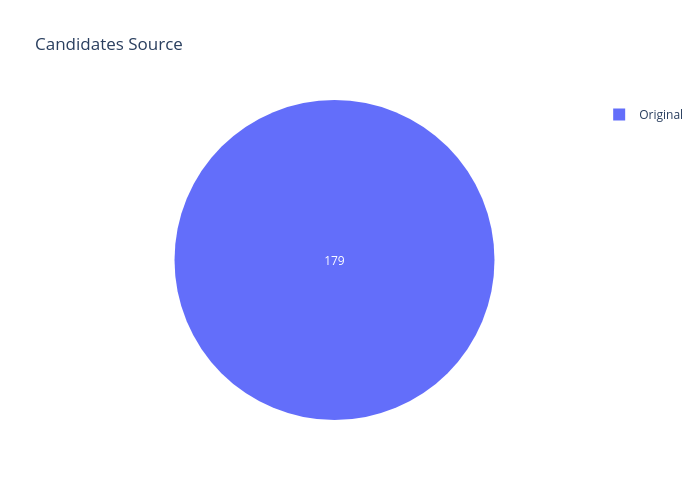

,Label,Count
0,Original,304


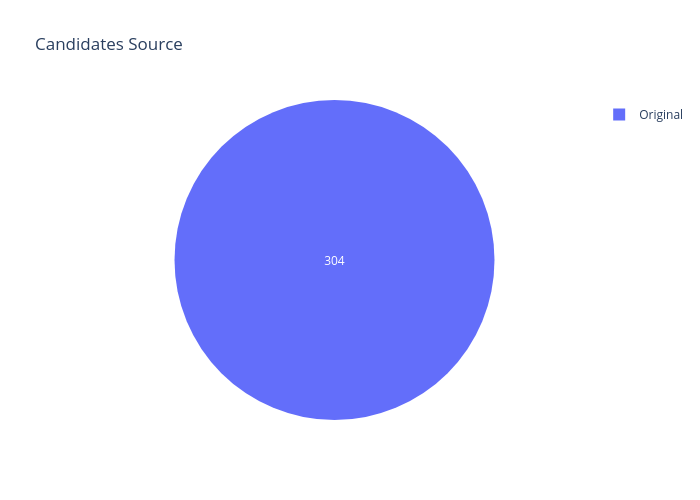

In [30]:
for _, row_data in choices_df.iterrows():
    func_name = row_data["func_name"]
    bb_name = row_data["bb_name"]
    func_bb_dir = WORK / f"{func_name}_{bb_name}_0"  # TODO: check suffix?
    pie2_csv = func_bb_dir / "pie2.csv"
    pie2_img = func_bb_dir / "pie2.png"
    display(HTML(f"<h2>Func: {func_name}, BB: {bb_name}</h2>"))
    display(pd.read_csv(pie2_csv))
    display(Image(pie2_img))

Profile

In [31]:
for _, row_data in choices_df.iterrows():
    func_name = row_data["func_name"]
    bb_name = row_data["bb_name"]
    func_bb_dir = WORK / f"{func_name}_{bb_name}_0"  # TODO: chekc suffix?
    times_csv = func_bb_dir / "times.csv"
    display(HTML(f"<h2>Func: {func_name}, BB: {bb_name}</h2>"))
    display(pd.read_csv(times_csv, index_col=False))

,Secs,Secs (rel.)
0,0.000087,0.000033
1,0.000166,0.000063
2,0.007761,0.002936
3,0.007662,0.002899
4,0.006533,0.002472
5,0.180667,0.068352
6,0.005764,0.002181
7,0.041060,0.015534
8,0.004705,0.001780
9,0.126127,0.047718


,Secs,Secs (rel.)
0,0.000082,0.000021
1,0.000172,0.000043
2,0.004746,0.001183
3,0.007595,0.001894
4,0.149957,0.037389
5,0.262388,0.065421
6,0.007791,0.001943
7,0.032357,0.008068
8,0.032047,0.007990
9,0.220197,0.054902


### Combined results

Pairwise overlaps

In [32]:
overlaps_file = WORK / "overlaps.csv"
pd.read_csv(overlaps_file)

,x,y,nodes,size
0,0,1,set(),0


Venn diagram

In [33]:
venn_file = WORK / "venn.jpg"
if len(choices_df) in [2, 3]:
    if venn_file.is_file():
        display(IFrame(venn_file, 700, 350))

Sankey diagram (duplicates vs. unqiue instructions)

In [34]:
sankey_file =  WORK / "sankey.md"
with open(sankey_file, "r") as f:
    content = f.read()
display(Markdown(content))


```mermaid
---
config:
  sankey:
    showValues: true
---
sankey-beta

%% source,target,value
Set0,Merged,4
Set1,Merged,8
Merged,Duplicates,0
Merged,Unique,12
Unique,Topk,12

```


### Analyse combined index

In [35]:
combined_index_yaml = WORK / "combined_index.yml"
import yaml
with open(combined_index_yaml, "r") as f:
    combined_index_data = yaml.safe_load(f)
# TODO: index and cdsl should use the same instruction names?
names = [f"CUSTOM{i}" for i, candidate in enumerate(combined_index_data["candidates"])]
num_candidates = len(names)
names_df = pd.DataFrame({"instr": names})
names_df["instr_lower"] = names_df["instr"].apply(lambda x: x.lower())
names_df

,instr,instr_lower
0,CUSTOM0,custom0
1,CUSTOM1,custom1
2,CUSTOM2,custom2
3,CUSTOM3,custom3
4,CUSTOM4,custom4
5,CUSTOM5,custom5
6,CUSTOM6,custom6
7,CUSTOM7,custom7
8,CUSTOM8,custom8
9,CUSTOM9,custom9


Number of candidates

In [36]:
num_candidates

12

## Generation of Instruction Set

Investigate generated Flat (unfused) CoreDSL per instruction

In [37]:
gen_dir = WORK / "gen"
for file in gen_dir.glob("*.flat"):
    display(HTML(f"<h3>File: {file.name}</h2>"))
    with open(file, "r") as f:
        code = f.read()
    display(Markdown(f"```c\n{code}\n```"""))

```c
// DateTime: 20241121T131947, Sub: 2, Name: name2, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(MUL((unsigned<32>)(ADD((unsigned<32>)(SRLI(rs1_val,(3))),(unsigned<32>)(SRLI(rs1_val,(31))))),rs2_val));
X[rd]=outp0;
```

```c
// DateTime: 20241121T131947, Sub: 8, Name: name8, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ADD(rs1_val,(unsigned<32>)(SRLI(rs2_val,(31)))));
X[rd]=outp0;
```

```c
// DateTime: 20241121T131947, Sub: 4, Name: name4, Inputs: 1, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ADD((unsigned<32>)(SRLI(rs1_val,(3))),(unsigned<32>)(SRLI(rs1_val,(31)))));
X[rd]=outp0;
```

```c
// DateTime: 20241121T131947, Sub: 10, Name: name10, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ADDI((unsigned<32>)(SUB(rs2_val,rs1_val)),(65)));
X[rd]=outp0;
```

```c
// DateTime: 20241121T131947, Sub: 0, Name: name0, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> temp0=(unsigned<32>)(MULH(rs2_val,(unsigned<32>)(ADDI(rs1_val,(-945)))));
unsigned<32> outp0=(unsigned<32>)(ADD((unsigned<32>)(SRLI(temp0,(3))),(unsigned<32>)(SRLI(temp0,(31)))));
X[rd]=outp0;
```

```c
// DateTime: 20241121T131947, Sub: 9, Name: name9, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ADD((unsigned<32>)(SRLI(rs2_val,(3))),rs1_val));
X[rd]=outp0;
```

```c
// DateTime: 20241121T131943, Sub: 6, Name: name6, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(SLLI((unsigned<32>)(ADD(rs1_val,rs2_val)),(1)));
X[rd]=outp0;
```

```c
// DateTime: 20241121T131943, Sub: 5, Name: name5, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(MUL(rs2_val,(unsigned<32>)(ADDI(rs1_val,(-403)))));
X[rd]=outp0;
```

```c
// DateTime: 20241121T131943, Sub: 3, Name: name3, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(SLLI((unsigned<32>)(ADD(rs2_val,(unsigned<32>)(ADDI(rs1_val,(57))))),(1)));
X[rd]=outp0;
```

```c
// DateTime: 20241121T131947, Sub: 1, Name: name1, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> temp0=(unsigned<32>)(MULH(rs2_val,rs1_val));
unsigned<32> outp0=(unsigned<32>)(ADD((unsigned<32>)(SRLI(temp0,(3))),(unsigned<32>)(SRLI(temp0,(31)))));
X[rd]=outp0;
```

```c
// DateTime: 20241121T131943, Sub: 7, Name: name7, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(ADD(rs2_val,(unsigned<32>)(ADDI(rs1_val,(57)))));
X[rd]=outp0;
```

```c
// DateTime: 20241121T131947, Sub: 11, Name: name11, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(MUL(rs2_val,(unsigned<32>)(ADDI(rs1_val,(26)))));
X[rd]=outp0;
```

CoreDSL Set with automatic encoding

In [38]:
set_file = WORK / "XIsaac.core_desc"

with open(set_file, "r") as f:
    code = f.read()

display(Markdown(f"```c\n{code}\n```"""))

```c
import "/work/git/isaac-demo/etiss_arch_riscv/rv_base/RVI.core_desc"

InstructionSet XIsaac extends RV32I {
    instructions {
        CUSTOM0 {
            encoding: 7'b0000000 :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom0", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> temp0 = (unsigned<32>)((((signed<32>)(((signed<64>)(((signed<32>)(rs2_val) * (signed<32>)((unsigned<32>)((((signed<32>)(rs1_val) + (signed<32>)((-945)))))))) >> 32)))));
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)((unsigned<32>)((((unsigned<32>)(temp0) >> (unsigned<32>)((3)))))) + (signed<32>)((unsigned<32>)((((unsigned<32>)(temp0) >> (unsigned<32>)((31)))))))));
                X[rd] = outp0;
            }
        }
        CUSTOM1 {
            encoding: 7'b0000001 :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom1", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> temp0 = (unsigned<32>)((((signed<32>)(((signed<64>)(((signed<32>)(rs2_val) * (signed<32>)(rs1_val))) >> 32)))));
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)((unsigned<32>)((((unsigned<32>)(temp0) >> (unsigned<32>)((3)))))) + (signed<32>)((unsigned<32>)((((unsigned<32>)(temp0) >> (unsigned<32>)((31)))))))));
                X[rd] = outp0;
            }
        }
        CUSTOM2 {
            encoding: 7'b0000010 :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom2", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)((unsigned<32>)((((signed<32>)((unsigned<32>)((((unsigned<32>)(rs1_val) >> (unsigned<32>)((3)))))) + (signed<32>)((unsigned<32>)((((unsigned<32>)(rs1_val) >> (unsigned<32>)((31)))))))))) * (signed<32>)(rs2_val))));
                X[rd] = outp0;
            }
        }
        CUSTOM3 {
            encoding: 7'b0000011 :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom3", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((signed<32>)(rs2_val) + (signed<32>)((unsigned<32>)((((signed<32>)(rs1_val) + (signed<32>)((57)))))))))) << (unsigned<32>)((1)))));
                X[rd] = outp0;
            }
        }
        CUSTOM4 {
            encoding: 7'b0000100 :: 5'b00000 :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom4", "{name(rd)}, {name(rs1)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)((unsigned<32>)((((unsigned<32>)(rs1_val) >> (unsigned<32>)((3)))))) + (signed<32>)((unsigned<32>)((((unsigned<32>)(rs1_val) >> (unsigned<32>)((31)))))))));
                X[rd] = outp0;
            }
        }
        CUSTOM5 {
            encoding: 7'b0000101 :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom5", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)(rs2_val) * (signed<32>)((unsigned<32>)((((signed<32>)(rs1_val) + (signed<32>)((-403)))))))));
                X[rd] = outp0;
            }
        }
        CUSTOM6 {
            encoding: 7'b0000110 :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom6", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((signed<32>)(rs1_val) + (signed<32>)(rs2_val))))) << (unsigned<32>)((1)))));
                X[rd] = outp0;
            }
        }
        CUSTOM7 {
            encoding: 7'b0000111 :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom7", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)(rs2_val) + (signed<32>)((unsigned<32>)((((signed<32>)(rs1_val) + (signed<32>)((57)))))))));
                X[rd] = outp0;
            }
        }
        CUSTOM8 {
            encoding: 7'b0001000 :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom8", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)(rs1_val) + (signed<32>)((unsigned<32>)((((unsigned<32>)(rs2_val) >> (unsigned<32>)((31)))))))));
                X[rd] = outp0;
            }
        }
        CUSTOM9 {
            encoding: 7'b0001001 :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom9", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)((unsigned<32>)((((unsigned<32>)(rs2_val) >> (unsigned<32>)((3)))))) + (signed<32>)(rs1_val))));
                X[rd] = outp0;
            }
        }
        CUSTOM10 {
            encoding: 7'b0001010 :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom10", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)((unsigned<32>)((((signed<32>)(rs2_val) - (signed<32>)(rs1_val))))) + (signed<32>)((65)))));
                X[rd] = outp0;
            }
        }
        CUSTOM11 {
            encoding: 7'b0001011 :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom11", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)(rs2_val) * (signed<32>)((unsigned<32>)((((signed<32>)(rs1_val) + (signed<32>)((26)))))))));
                X[rd] = outp0;
            }
        }
    }
}


```

## LLVM Retargeting

## Seal5 Reports

In [39]:
reports_dir = WORK / "docker" / "seal5_reports"

### Properties

In [40]:
properties_csv = reports_dir / "properties.csv"
pd.read_csv(properties_csv)

,model,set,xlen,is_rv32,is_rv64,instr,enc_size,is_compressed,enc_format,opcode,...,is_siso,is_simo,has_imm_leaf,has_side_effects,may_load,may_store,is_terminator,is_branch,uses_custom_reg,defs_custom_reg
0,XIsaac,XIsaac,32,True,False,CUSTOM0,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
1,XIsaac,XIsaac,32,True,False,CUSTOM1,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
2,XIsaac,XIsaac,32,True,False,CUSTOM2,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
3,XIsaac,XIsaac,32,True,False,CUSTOM3,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
4,XIsaac,XIsaac,32,True,False,CUSTOM4,32,False,r-type (unop),custom-3,...,True,False,False,False,False,False,False,False,False,False
5,XIsaac,XIsaac,32,True,False,CUSTOM5,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
6,XIsaac,XIsaac,32,True,False,CUSTOM6,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
7,XIsaac,XIsaac,32,True,False,CUSTOM7,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
8,XIsaac,XIsaac,32,True,False,CUSTOM8,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
9,XIsaac,XIsaac,32,True,False,CUSTOM9,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False


### Stage Times

In [41]:
stage_times_csv = reports_dir / "stage_times.csv"
pd.read_csv(stage_times_csv)[["stage", "time_s"]].dropna()

,stage,time_s
0,setup,38.525705
1,patch,18.895561
2,build,873.806360
3,transform,1.494864
4,generate,1.391977
5,patch,11.247329
6,build,59.838384
7,build,7.436642
8,build,7.464818
9,generate,2.049902


### Passes

In [42]:
seal5_status_csv = reports_dir / "status.csv"
seal5_status_compact_csv = reports_dir / "status_compact.csv"
seal5_status_df = pd.read_csv(seal5_status_csv)
seal5_status_compact_df = pd.read_csv(seal5_status_compact_csv)
seal5_status_compact_df

,model,set,xlen,instr,n_success,n_skipped,n_failed,n_total,status
0,XIsaac,XIsaac,32,CUSTOM0,12,0,0,12,good
1,XIsaac,XIsaac,32,CUSTOM1,12,0,0,12,good
2,XIsaac,XIsaac,32,CUSTOM2,12,0,0,12,good
3,XIsaac,XIsaac,32,CUSTOM3,12,0,0,12,good
4,XIsaac,XIsaac,32,CUSTOM4,12,0,0,12,good
5,XIsaac,XIsaac,32,CUSTOM5,12,0,0,12,good
6,XIsaac,XIsaac,32,CUSTOM6,12,0,0,12,good
7,XIsaac,XIsaac,32,CUSTOM7,12,0,0,12,good
8,XIsaac,XIsaac,32,CUSTOM8,12,0,0,12,good
9,XIsaac,XIsaac,32,CUSTOM9,12,0,0,12,good


### Test Results/Coverage

In [43]:
# test_coverage_compact_csv = reports_dir / "test_coverage_compact.csv"
# pd.read_csv(test_coverage_compact_csv)

In [44]:
# test_results_compact_csv = reports_dir / "test_results_compact.csv"
# pd.read_csv(test_results_compact_csv)

### Changed Files/Lines

In [45]:
seal5_diff_csv = reports_dir / "diff.csv"
seal5_diff_df = pd.read_csv(seal5_diff_csv)
seal5_diff_df

,phase,n_files_changed,n_insertions,n_deletions
0,PHASE_0,29,4402,5
1,PHASE_1,3,15,0
2,PHASE_2,14,529,0
3,PHASE_3,0,0,0
4,PHASE_4,13,132,0
5,PHASE_5,0,0,0
6,*,55,5078,5


### Seal5 Score

In [46]:
seal5_score_data = []
seal5_pattern_gen_status_df = seal5_status_df[seal5_status_df["pass"] == "generate_passes.pattern_gen.behav_to_pat"][["instr", "status"]]
seal5_passes_status_df = seal5_status_compact_df[["instr", "status"]]
# print("seal5_passes_status_df", seal5_passes_status_df)
for instr_name in seal5_status_df["instr"].unique():
    # print("instr_name", instr_name)
    passes_status = seal5_passes_status_df[seal5_passes_status_df["instr"] == instr_name]
    assert len(passes_status) == 1
    passes_status = passes_status["status"].iloc[0]
    passes_score = 1.0 if passes_status == "good" else (0.5 if passes_status == "ok" else 0.0)
    
    pattern_gen_status = seal5_pattern_gen_status_df[seal5_pattern_gen_status_df["instr"] == instr_name]
    assert len(pattern_gen_status) == 1
    pattern_gen_status = pattern_gen_status["status"].iloc[0]
    # print("pattern_gen_status", pattern_gen_status)
    pattern_gen_score = 1.0 if pattern_gen_status == "success" else -1.0
    # print("pattern_gen_score", pattern_gen_score)
    
    new = {"instr": instr_name, "pattern_gen_score": pattern_gen_score, "passes_score": passes_score}
    seal5_score_data.append(new)
    
def calc_seal5_score(x):
    return x.min()

seal5_score_df = pd.DataFrame(seal5_score_data)
seal5_score_df["seal5_score"] =  seal5_score_df[["pattern_gen_score", "passes_score"]].apply(calc_seal5_score, axis=1)
seal5_score_df
# TODO: write to file

,instr,pattern_gen_score,passes_score,seal5_score
0,CUSTOM0,1.0,1.0,1.0
1,CUSTOM1,1.0,1.0,1.0
2,CUSTOM2,1.0,1.0,1.0
3,CUSTOM3,1.0,1.0,1.0
4,CUSTOM4,1.0,1.0,1.0
5,CUSTOM5,1.0,1.0,1.0
6,CUSTOM6,1.0,1.0,1.0
7,CUSTOM7,1.0,1.0,1.0
8,CUSTOM8,1.0,1.0,1.0
9,CUSTOM9,1.0,1.0,1.0


## ISS Evaluation

In [50]:
RUN_COMPARE = Path(str(RUN) + "_compare")
REPORT_COMPARE = RUN_COMPARE / "report.csv"

COLS = ["Model", "Arch", "Run Instructions", "Run Instructions (rel.)"]
bench_compare_df = pd.read_csv(REPORT_COMPARE)[COLS]
bench_compare_df

,Model,Arch,Run Instructions,Run Instructions (rel.)
0,tarfind,rv32imfd,1212314,1.000000
1,tarfind,rv32imfd_xisaac,1103744,0.910444


In [51]:
RUN_COMPARE_MEM = Path(str(RUN) + "_compare_mem")
REPORT_COMPARE_MEM = RUN_COMPARE_MEM / "report.csv"

COLS = ["Model", "Arch", "Total ROM", "Total RAM", "ROM code", "ROM code (rel.)"]
bench_compare_mem_df = pd.read_csv(REPORT_COMPARE_MEM)[COLS]
bench_compare_mem_df

,Model,Arch,Total ROM,Total RAM,ROM code,ROM code (rel.)
0,tarfind,rv32imfd,3544,10212,3468,1.000000
1,tarfind,rv32imfd_xisaac,3528,10212,3452,0.995386


### MLonMCU Score (Set)

In [53]:
assert len(bench_compare_df) == 2
run_instrs_rel = bench_compare_df["Run Instructions (rel.)"].iloc[-1]
assert len(bench_compare_mem_df) == 2
rom_code_rel = bench_compare_mem_df["ROM code (rel.)"].iloc[-1]

run_instrs_score = 1.0/run_instrs_rel-1
rom_code_score = 1.0/rom_code_rel-1

# TODO: cycles!

RUN_INSTR_WEIGHT_POS = 2
ROM_CODE_WEIGHT_POS = 1
RUN_INSTR_WEIGTH_NEG = 10
ROM_CODE_WEIGHT_NEG = 2

mlonmcu_set_score_data = [{"set": "XIsaac", "run_instrs_score": run_instrs_score, "rom_code_score": rom_code_score}]

def calc_mlonmcu_score(x):
    # return gmean([x["run_instrs_score"], x["rom_code_score"]], weights=[RUN_INSTR_WEIGHT, ROM_CODE_WEIGHT])
    a = x["run_instrs_score"]
    a = a * RUN_INSTR_WEIGHT_POS if a > 0 else a * RUN_INSTR_WEIGTH_NEG
    print(a)
    b = x["rom_code_score"]
    b = b * ROM_CODE_WEIGHT_POS if b > 0 else b * ROM_CODE_WEIGHT_NEG
    print(b)
    temp = a + b
    return max(-1.0, min(1.0, temp))

mlonmcu_set_score_df = pd.DataFrame(mlonmcu_set_score_data)
mlonmcu_set_score_df["mlonmcu_score"] =  mlonmcu_set_score_df[["run_instrs_score", "rom_code_score"]].apply(calc_mlonmcu_score, axis=1)
mlonmcu_set_score_df
# TODO: write to file

0.19673040125246422
0.004634994206257348


,set,run_instrs_score,rom_code_score,mlonmcu_score
0,XIsaac,0.098365,0.004635,0.201365


## Dynamic Analysis

In [54]:
SESS_NEW = DATE_DIR / "sess_new"
PLOTS_DIR_NEW = SESS_NEW / "plots"

In [55]:
IFrame(PLOTS_DIR_NEW / "runtime_per_llvm_bb.jpg", 700, 350)

In [56]:
IFrame(PLOTS_DIR_NEW / "runtime_per_func.jpg", 700, 350)

In [57]:
IFrame(PLOTS_DIR_NEW / "runtime_per_opcode.jpg", 700, 350)

In [58]:
IFrame(PLOTS_DIR_NEW / "runtime_per_instr.jpg", 700, 350)

In [59]:
opcodes_hist_file = SESS_NEW / "table" / "opcodes_hist.pkl"
opcodes_hist_df = pd.read_pickle(opcodes_hist_file)
print("All opcodes:")
display(opcodes_hist_df)
print("Custom only:")
display(opcodes_hist_df[opcodes_hist_df["opcode"].apply(lambda x: "custom" in x)])

All opcodes:


,opcode,count,rel_count
0,OP-IMM,313217,0.279336
1,OP,163720,0.146010
2,LUI,109107,0.097305
3,STORE (Compressed),103101,0.091948
4,STORE,101651,0.090655
5,BRANCH,93685,0.083551
6,LOAD,58569,0.052234
7,JALR,39467,0.035198
8,JAL,38690,0.034505
9,custom-3/rv128,36190,0.032275


Custom only:


,opcode,count,rel_count
9,custom-3/rv128,36190,0.032275


In [60]:
instrs_hist_file = SESS_NEW / "table" / "instrs_hist.pkl"
instrs_hist_df = pd.read_pickle(instrs_hist_file)
print("All instructions:")
display(instrs_hist_df)
print("Custom only:")
custom_instrs_hist_df = instrs_hist_df[instrs_hist_df["instr"].apply(lambda x: "custom" in x)]
display(custom_instrs_hist_df)

All instructions:


,instr,count,rel_count
0,addi,192759,1.719081e-01
1,lui,109107,9.730480e-02
2,csw,102092,9.104862e-02
3,srli,72383,6.455327e-02
4,sb,64746,5.774237e-02
...,...,...,...
60,ori,11,9.810121e-06
61,csrai,6,5.350975e-06
62,or,4,3.567317e-06
63,sll,2,1.783658e-06


Custom only:


,instr,count,rel_count
15,custom2,36190,0.032275


In [61]:
# temp
instrs_hist_file = SESS_NEW / "table" / "instrs_hist.pkl"
instrs_hist_df = pd.read_pickle(instrs_hist_file)
print("All instructions:")
display(instrs_hist_df)
print("Custom only:")
custom_instrs_hist_df = instrs_hist_df[instrs_hist_df["instr"].apply(lambda x: "custom" in x)]
display(custom_instrs_hist_df)

All instructions:


,instr,count,rel_count
0,addi,192759,1.719081e-01
1,lui,109107,9.730480e-02
2,csw,102092,9.104862e-02
3,srli,72383,6.455327e-02
4,sb,64746,5.774237e-02
...,...,...,...
60,ori,11,9.810121e-06
61,csrai,6,5.350975e-06
62,or,4,3.567317e-06
63,sll,2,1.783658e-06


Custom only:


,instr,count,rel_count
15,custom2,36190,0.032275


In [62]:
dyn_counts_score_data = []

merged_custom_instrs_hist_df = pd.merge(names_df, custom_instrs_hist_df, how="outer", left_on="instr_lower", right_on="instr", suffixes=('', '_y'))

COUNT_WEIGHT = 1
CUSTOM_COUNT_WEIGHT = 1

instr_count_sum = instrs_hist_df["count"].sum()
instr_count_max = instrs_hist_df["count"].max()
print("instr_count", instr_count_sum, instr_count_max)
custom_count_sum = merged_custom_instrs_hist_df["count"].sum()
custom_count_max = merged_custom_instrs_hist_df["count"].max()
print("custom_count", custom_count_sum, custom_count_max)

for _, row_df in merged_custom_instrs_hist_df.iterrows():
    instr = row_df["instr"]
    count = row_df["count"]
    # rel_count = row_df["rel_count"]
    used = count > 0
    used_score = 1.0 if used else -1.0
    count_score = count/instr_count_max if used else -1.0
    custom_count_score = count/custom_count_max if used else -1.0
    new = {"instr": instr, "used_score": used_score, "count_score": count_score, "custom_count_score": custom_count_score}
    dyn_counts_score_data.append(new)

dyn_counts_score_df = pd.DataFrame(dyn_counts_score_data)
dyn_counts_score_df
# TODO: write to file

instr_count 1121291 192759
custom_count 36190.0 36190.0


,instr,used_score,count_score,custom_count_score
0,CUSTOM0,-1.0,-1.000000,-1.0
1,CUSTOM1,-1.0,-1.000000,-1.0
2,CUSTOM2,1.0,0.187747,1.0
3,CUSTOM3,-1.0,-1.000000,-1.0
4,CUSTOM4,-1.0,-1.000000,-1.0
5,CUSTOM5,-1.0,-1.000000,-1.0
6,CUSTOM6,-1.0,-1.000000,-1.0
7,CUSTOM7,-1.0,-1.000000,-1.0
8,CUSTOM8,-1.0,-1.000000,-1.0
9,CUSTOM9,-1.0,-1.000000,-1.0


## Static Analysis

### Instructions

In [223]:
disass_instrs_hist_file = SESS_NEW / "table" / "disass_instrs_hist.pkl"
disass_instrs_hist_df = pd.read_pickle(disass_instrs_hist_file)
print("All instructions:")
display(disass_instrs_hist_df)
print("Custom only:")
diass_custom_instrs_hist_df = disass_instrs_hist_df[disass_instrs_hist_df["instr"].apply(lambda x: "custom" in x)]
display(diass_custom_instrs_hist_df)
print("Pie:")
display(IFrame(PLOTS_DIR_NEW / "disass_counts_per_instr.jpg", 700, 350))

All instructions:


,instr,count,rel_count
0,sw,2233,0.144634
1,lw,2201,0.142561
2,addi,1623,0.105123
3,li,1151,0.074551
4,mv,1120,0.072544
...,...,...,...
83,rdinstret,1,0.000065
84,rdcycle,1,0.000065
85,divu,1,0.000065
86,fneg.d,1,0.000065


Custom only:


,instr,count,rel_count
52,custom1,11,0.000712
55,custom10,9,0.000583
54,custom7,9,0.000583
53,custom2,9,0.000583


Pie:


In [230]:
# temp
disass_instrs_hist_file = SESS_NEW / "table" / "disass_instrs_hist.pkl"
disass_instrs_hist_df = pd.read_pickle(disass_instrs_hist_file)
print("All instructions:")
display(disass_instrs_hist_df)
print("Custom only:")
diass_custom_instrs_hist_df = disass_instrs_hist_df[disass_instrs_hist_df["instr"].apply(lambda x: "custom" in x)]
display(diass_custom_instrs_hist_df)
print("Pie:")
display(IFrame(PLOTS_DIR_NEW / "disass_counts_per_instr.jpg", 700, 350))

All instructions:


,instr,count,rel_count
0,sw,2230,0.144141
1,lw,2198,0.142072
2,addi,1623,0.104906
3,li,1151,0.074397
4,mv,1118,0.072264
...,...,...,...
80,rdinstret,1,0.000065
81,slt,1,0.000065
82,rdcycle,1,0.000065
83,csrw,1,0.000065


Custom only:


,instr,count,rel_count
40,custom0,27,0.001745


Pie:


In [208]:
static_counts_score_data = []

merged_diass_custom_instrs_hist_df = pd.merge(names_df, diass_custom_instrs_hist_df, how="outer", left_on="instr_lower", right_on="instr", suffixes=('', '_y'))

COUNT_WEIGHT = 1
CUSTOM_COUNT_WEIGHT = 1

instr_count_sum = disass_instrs_hist_df["count"].sum()
instr_count_max = disass_instrs_hist_df["count"].max()
print("instr_count", instr_count_sum, instr_count_max)
custom_count_sum = merged_diass_custom_instrs_hist_df["count"].sum()
custom_count_max = merged_diass_custom_instrs_hist_df["count"].max()
print("custom_count", custom_count_sum, custom_count_max)

for _, row_df in merged_diass_custom_instrs_hist_df.iterrows():
    instr = row_df["instr"]
    count = row_df["count"]
    # rel_count = row_df["rel_count"]
    used = count > 0
    used_score = 1.0 if used else -1.0
    count_score = count/instr_count_max if used else -1.0
    custom_count_score = count/custom_count_max if used else -1.0
    new = {"instr": instr, "used_score": used_score, "count_score": count_score, "custom_count_score": custom_count_score}
    static_counts_score_data.append(new)

static_counts_score_df = pd.DataFrame(static_counts_score_data)
static_counts_score_df
# TODO: write to file

instr_count 15439 2233
custom_count 38.0 11.0


,instr,used_score,count_score,custom_count_score
0,CUSTOM0,-1.0,-1.000000,-1.000000
1,CUSTOM1,1.0,0.004926,1.000000
2,CUSTOM2,1.0,0.004030,0.818182
3,CUSTOM3,-1.0,-1.000000,-1.000000
4,CUSTOM4,-1.0,-1.000000,-1.000000
5,CUSTOM5,-1.0,-1.000000,-1.000000
6,CUSTOM6,-1.0,-1.000000,-1.000000
7,CUSTOM7,1.0,0.004030,0.818182
8,CUSTOM8,-1.0,-1.000000,-1.000000
9,CUSTOM9,-1.0,-1.000000,-1.000000


### Opcodes

In [95]:
disass_opcodes_hist_file = SESS_NEW / "table" / "disass_opcodes_hist.pkl"
disass_opcodes_hist_df = pd.read_pickle(disass_opcodes_hist_file)
print("All instructions:")
display(disass_opcodes_hist_df)
print("Custom only:")
display(disass_opcodes_hist_df[disass_opcodes_hist_df["opcode"].apply(lambda x: "custom" in x)])
print("Pie:")
display(IFrame(PLOTS_DIR_NEW / "disass_counts_per_opcode.jpg", 700, 350))

All instructions:


,opcode,count,rel_count
0,OP-IMM (Compressed),2216,0.143533
1,OP-IMM,1843,0.119373
2,STORE (Compressed),1709,0.110694
3,JALR (Compressed),1690,0.109463
4,LOAD (Compressed),1643,0.106419
5,BRANCH,1252,0.081093
6,OP,1118,0.072414
7,LOAD,827,0.053566
8,STORE,699,0.045275
9,JAL (Compressed),656,0.042490


Custom only:


,opcode,count,rel_count
16,custom-3/rv128,38,0.002461


Pie:


In [65]:
# TODO: write utilization to file


In [92]:
PLOTS_DIR_NEW / "disass_counts_per_opcode.jpg"

PosixPath('out/nettle-aes/20241111T162222/sess_new/plots/disass_counts_per_opcode.jpg')

## HLS Metrics

In [35]:
hls_metrics_csv = WORK / "docker" / "hls" / "hls_metrics.csv"
display(pd.read_csv(hls_metrics_csv))

,instruction,mask,tags,schedule,latency
0,CUSTOM0,0000000----------000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0
1,CUSTOM1,0000001----------000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0
2,CUSTOM2,0000010----------000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0
3,CUSTOM3,000001100000-----000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0
4,CUSTOM4,000010000000-----000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0
5,CUSTOM5,000010100000-----000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0
6,CUSTOM6,000011000000-----000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0
7,CUSTOM7,0000111----------000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0
8,CUSTOM8,0001000----------000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0
9,CUSTOM9,0001001----------000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0


## HW Synthesis Metrics

In [67]:
syn_best_csv = WORK / "docker" / "hls" / "syn_dir" / "best.csv"
display(pd.read_csv(syn_best_csv))

,prj_name,period_ns,util,best
0,prj,34.4827,40.0,True


In [69]:
syn_metrics_csv = WORK / "docker" / "hls" / "syn_metrics.csv"
display(pd.read_csv(syn_metrics_csv))
# TODO: store baseline (without ext)!

,Project,Clock Period [s],Clock Period [ns],Clock Freq [Hz],Clock Freq [MHz],FP Util,Instance Count,Instance Area,Internal Power,Switching Power,Leakage Power,Total Power,IOs,Die Area,Core Area,Instance Utilization,Est. Wire Length
0,prj,3.448276e-08,34.482759,29000000.0,29.0,0.4,16651,141159,0.010185,0.010012,1.658758e-07,0.020197,308,308774,290348,0.486171,446787


In [70]:
# TODO: performance estimator?